# Modeling

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

# sklearn preprocessing
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.pipeline import Pipeline

# sklearn metrics and validation
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, \
f1_score, plot_confusion_matrix, plot_roc_curve, recall_score, \
classification_report, roc_auc_score, make_scorer 

# xgboost
import xgboost

In [2]:
# loading the dataset
df = pd.read_csv('./Data/syriatel_clean.csv', index_col=0)

In [3]:
df

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,...,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,total_minutes,total_calls,total_charge
0,KS,128,0,1,25,265.1,110,45.07,197.4,99,...,91,11.01,10.0,3,2.70,1,0,717.2,303,75.56
1,OH,107,0,1,26,161.6,123,27.47,195.5,103,...,103,11.45,13.7,3,3.70,1,0,625.2,332,59.24
2,NJ,137,0,0,0,243.4,114,41.38,121.2,110,...,104,7.32,12.2,5,3.29,0,0,539.4,333,62.29
3,OH,84,1,0,0,299.4,71,50.90,61.9,88,...,89,8.86,6.6,7,1.78,2,0,564.8,255,66.80
4,OK,75,1,0,0,166.7,113,28.34,148.3,122,...,121,8.41,10.1,3,2.73,3,0,512.0,359,52.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,0,1,36,156.2,77,26.55,215.5,126,...,83,12.56,9.9,6,2.67,2,0,660.7,292,60.10
3329,WV,68,0,0,0,231.1,57,39.29,153.4,55,...,123,8.61,9.6,4,2.59,3,0,585.4,239,63.53
3330,RI,28,0,0,0,180.8,109,30.74,288.8,58,...,91,8.64,14.1,6,3.81,2,0,675.6,264,67.74
3331,CT,184,1,0,0,213.8,105,36.35,159.6,84,...,137,6.26,5.0,10,1.35,2,0,517.6,336,57.53


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   international plan      3333 non-null   int64  
 3   voice mail plan         3333 non-null   int64  
 4   number vmail messages   3333 non-null   int64  
 5   total day minutes       3333 non-null   float64
 6   total day calls         3333 non-null   int64  
 7   total day charge        3333 non-null   float64
 8   total eve minutes       3333 non-null   float64
 9   total eve calls         3333 non-null   int64  
 10  total eve charge        3333 non-null   float64
 11  total night minutes     3333 non-null   float64
 12  total night calls       3333 non-null   int64  
 13  total night charge      3333 non-null   float64
 14  total intl minutes      3333 non-null   

## Business Understanding

For this business task, the company wants to use this model to predict whether a customer will churn or not. Once they identify customers who are likely to churn they are going to reach out to them and provide them with incentives to stay with the company. For this reason, the company wants to minimize False Negatives as they do not want to lose out on customers who are about to churn. Customer acquisition costs much higher than customer retention so they do not want to customers who are about to churn to go unnoticed.

## Correlation

<AxesSubplot:>

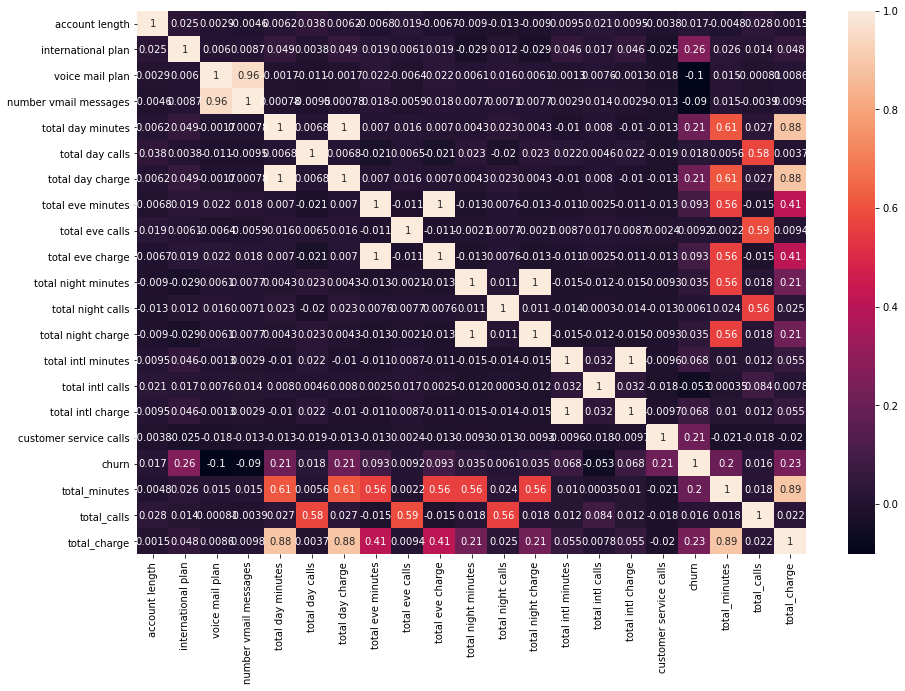

In [5]:
# fig ax set up
fig, ax = plt.subplots(figsize=(15,10))

# heatmatp
sns.heatmap(data=df.corr(), annot=True)

I am going to get rid of the following columns for right due to mulitcollinearity:

anything column with charge, total_minutes, total_calls, total_charge, number of voicemail messages

In [6]:
cols_to_drop = ['number vmail messages', 'total day charge', 'total eve charge',
               'total night charge', 'total_minutes', 'total_calls', 'total_charge',
               'total intl charge']

# new df
df2 = df.drop(columns=cols_to_drop)

<AxesSubplot:>

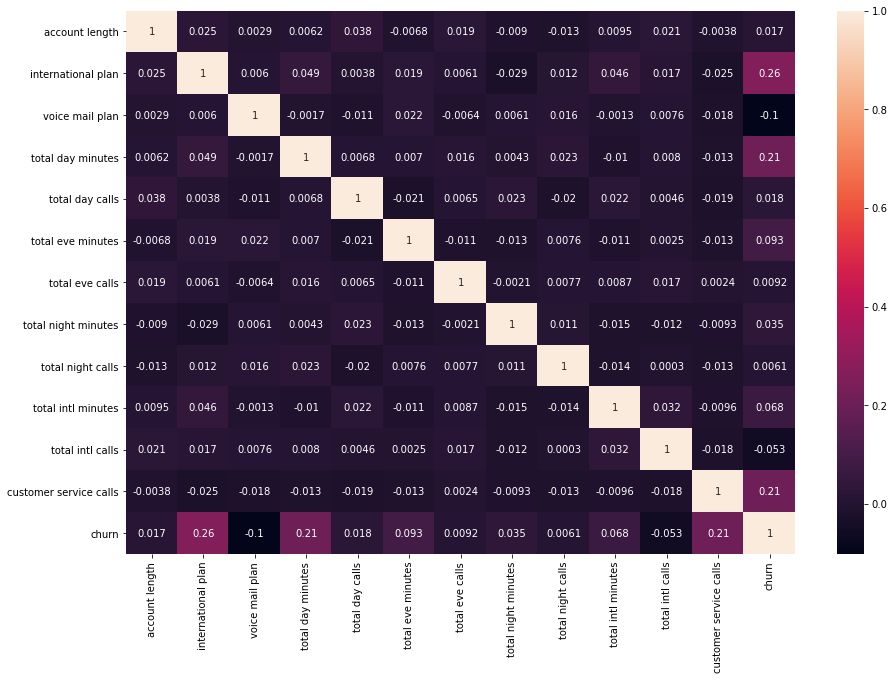

In [7]:
# fig ax set up
fig, ax = plt.subplots(figsize=(15,10))

# heatmatp
sns.heatmap(data=df2.corr(), annot=True)

## Train Test Split

In [8]:
# split data frame
X = df2.drop(columns=['churn', 'state'])
y = df2['churn']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, 
                                                   test_size=0.3, stratify=y)

## Preprocessing and Helper Functions

In [9]:
# standardize training and test data

# X_train_trim = X_train.drop(columns=col_drop)
# X_test_trim = X_test.drop(columns=col_drop)

# standardize train and test
ss = StandardScaler()
X_train_sc = pd.DataFrame(ss.fit_transform(X_train), 
                          columns=X_train.columns,
                          index=X_train.index)

X_test_sc = pd.DataFrame(ss.transform(X_test), 
                         columns=X_test.columns,
                         index=X_test.index)

# concat scaled data and cat columns
# X_train_sc = pd.concat([X_train_sc, X_train[cat_cols]], axis=1)
# X_test_sc = pd.concat([X_test_sc, X_test[cat_cols]], axis=1)

In [10]:
X_test_sc

,account length,international plan,voice mail plan,total day minutes,total day calls,total eve minutes,total eve calls,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls
68,0.635777,-0.318608,-0.628757,0.591610,-1.510956,0.303368,-1.010251,-0.942862,-2.052450,-0.856263,-1.443780,-0.432951
1653,-0.188705,3.138656,-0.628757,-0.895386,-1.111680,0.358179,0.285716,-0.898720,0.151124,0.305127,-1.031044,-0.432951
1716,-1.612809,-0.318608,1.590440,-0.498607,0.485425,0.810373,-1.658234,-1.065254,-1.335008,-0.398746,-1.031044,-0.432951
3251,-0.313626,-0.318608,-0.628757,1.759699,0.235878,-0.788944,1.033389,-0.122234,1.176042,-0.363552,-0.205572,0.336923
2406,-0.488516,-0.318608,-0.628757,-0.632103,-2.059961,1.693227,1.531838,-0.377050,1.073550,-0.363552,-0.205572,0.336923
...,...,...,...,...,...,...,...,...,...,...,...,...
1698,0.810667,-0.318608,-0.628757,0.408053,-0.762313,-0.626468,0.784165,1.721671,-1.027532,-1.489749,-0.205572,-1.202826
2780,-0.588453,-0.318608,-0.628757,0.115103,-0.263218,0.207448,-0.113043,1.641414,-0.976286,0.375515,-0.205572,1.106798
1533,0.660761,3.138656,-0.628757,1.158967,0.086149,0.483462,-1.010251,1.033467,-0.207598,1.290550,0.207164,0.336923
2934,-1.912621,-0.318608,-0.628757,-0.569063,-1.361228,-1.378166,-0.960406,0.764606,-1.591237,-0.574714,-0.618308,0.336923


In [11]:
X_train_sc

,account length,international plan,voice mail plan,total day minutes,total day calls,total eve minutes,total eve calls,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls
606,0.710730,-0.318608,-0.628757,-0.745204,0.934611,1.720633,0.235871,-1.426410,-0.156352,1.009001,1.445373,-1.202826
2468,1.285368,3.138656,1.590440,-0.609853,1.383797,1.648204,-0.212733,0.263000,-1.027532,-2.088041,-1.031044,-0.432951
1844,-0.588453,-0.318608,1.590440,-0.811951,0.834792,0.843651,0.086337,0.140608,-1.335008,0.445902,-0.618308,1.876673
3187,-1.063155,-0.318608,1.590440,0.597172,-3.008242,1.428958,-1.209630,0.200801,1.995977,-1.700911,-0.205572,-0.432951
3083,1.835023,-0.318608,-0.628757,1.034742,0.385606,-1.156963,2.129976,2.331624,1.586009,0.797839,0.207164,-1.202826
...,...,...,...,...,...,...,...,...,...,...,...,...
2670,0.385934,-0.318608,1.590440,0.765896,0.385606,-0.986657,0.883855,-0.431223,-1.027532,-0.433939,0.619900,0.336923
2165,1.485243,-0.318608,-0.628757,-0.157451,0.136059,0.824076,1.033389,-0.447275,-0.412581,0.973807,-0.618308,0.336923
2988,0.111107,-0.318608,-0.628757,1.476020,-0.213308,-0.512930,-0.162888,0.439565,-3.282352,0.621870,0.207164,1.106798
179,-0.763343,-0.318608,-0.628757,0.971702,1.084340,1.779360,0.584785,0.014203,0.612337,-3.601369,-1.856517,1.106798


In [12]:
# function for printing out metrics and plots
def print_metrics(estimator, X_test, y_test):
    
    # plot confusiont matrix
    plot_confusion_matrix(estimator,
                     X=X_test,
                     y_true=y_test)
    
    # metrics
    y_pred = estimator.predict(X_test)

    print('Accuracy score:', round(accuracy_score(y_test, y_pred), 3))
    print('Precision score:', round(precision_score(y_test, y_pred), 3))
    print('Recall score:', round(recall_score(y_test, y_pred), 3))
    print('ROC AUC score:', round(roc_auc_score(y_test, estimator.predict_proba(X_test)[:, 1]), 3))

#     # ROC_AUC curve
#     plot_roc_curve(estimator, X=X_test, y=y_test)

## Baseline Model (Dummy Model)

In [13]:
# instantiate DummyClassifier
dum = DummyClassifier(strategy='most_frequent')

# fit training data
dum.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [14]:
# creating Dummy Pipeline
dum_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('dummy_model', DummyClassifier(strategy='most_frequent'))
])

In [15]:
dum_pipe.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('dummy_model', DummyClassifier(strategy='most_frequent'))])

Accuracy score: 0.855
Precision score: 0.0
Recall score: 0.0
ROC AUC score: 0.5


C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


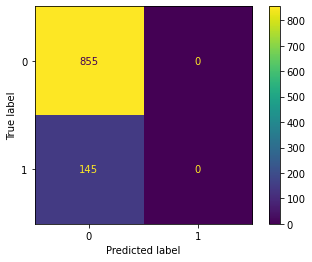

In [16]:
print_metrics(dum_pipe, X_test, y_test)

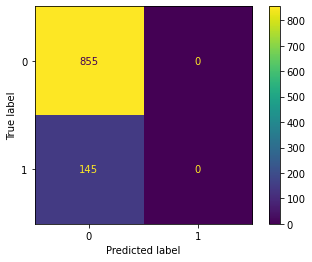

In [17]:
plot_confusion_matrix(dum,
                     X=X_test,
                     y_true=y_test)

In [18]:
# metrics
y_pred = dum.predict(X_test)

print('Accuracy score:', accuracy_score(y_test, y_pred))
print('Precision score:', precision_score(y_test, y_pred))
print('Recall score:', recall_score(y_test, y_pred))

Accuracy score: 0.855
Precision score: 0.0
Recall score: 0.0


C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


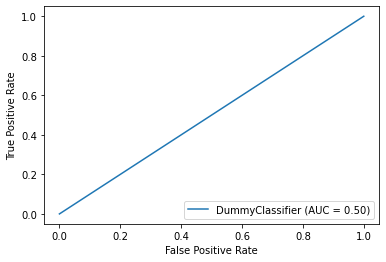

In [19]:
# ROC_AUC curve
plot_roc_curve(dum,
                X=X_test,
                y=y_test)

Dummy Model:
* Dummy model is set up to only predict the most frequent class which in this case is 0 (customers who have not churned).
* Metrics for this are accuracy of 85.5%, precision of 0%, recall of 0%, and ROC_AUC of 0.50.

## Logistic Regression Pipeline

Next model to set up is a logistic regression model. I'll start by using all columns except for state and totals to predict churn.

In [20]:
# logreg pipeline
logreg_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('logreg', LogisticRegression(penalty='none'))
])

Accuracy score: 0.866
Precision score: 0.587
Recall score: 0.255
ROC AUC score: 0.813


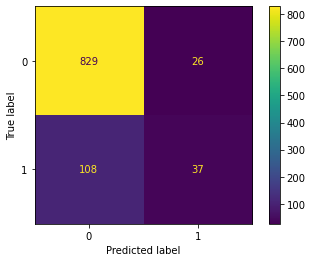

In [21]:
# fit and get metrics for logistic regression
logreg_pipe.fit(X_train, y_train)
logreg_pipe.score(X_test, y_test)

# print metrics
print_metrics(logreg_pipe, X_test, y_test)

Now I am going to try to use the features that are most correlated to churn.

In [22]:
# top 3 correlated features
high_corr_feats = df2.corr().churn.sort_values(ascending=False).index[1:4]
print(high_corr_feats)

Index(['international plan', 'customer service calls', 'total day minutes'], dtype='object')


In [23]:
# fit it to logistic regression model
logreg_pipe.fit(X_train[high_corr_feats], y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('logreg', LogisticRegression(penalty='none'))])

Accuracy score: 0.86
Precision score: 0.547
Recall score: 0.2
ROC AUC score: 0.809


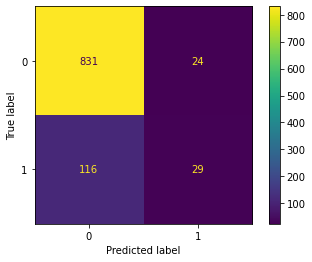

In [24]:
# print metrics
print_metrics(logreg_pipe, X_test[high_corr_feats], y_test)

## Decision Tree Pipeline

In [25]:
# DecisionTree pipeline
dcf_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('dcf', DecisionTreeClassifier(max_depth=5))
])

Accuracy score: 0.957
Precision score: 0.961
Recall score: 0.731
ROC AUC score: 0.923


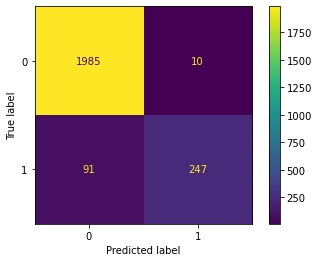

In [26]:
# fit decision tree
dcf_pipe.fit(X_train, y_train)

# print train metrics
print_metrics(dcf_pipe, X_train, y_train)

In [27]:
cross_val_score(dcf_pipe,
               X=X_train,
               y=y_train).mean()

0.9365679940447198

Accuracy score: 0.938
Precision score: 0.911
Recall score: 0.634
ROC AUC score: 0.822


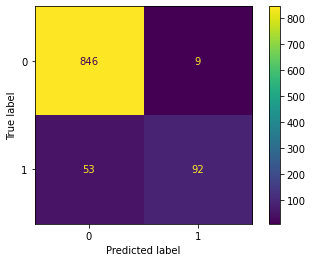

In [28]:
print_metrics(dcf_pipe, X_test, y_test)

## K Nearest Neighbors

In [29]:
# KNN pipeline
knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [30]:
# fit to training data
knn.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('knn', KNeighborsClassifier())])

Accuracy score: 0.922
Precision score: 0.92
Recall score: 0.509
ROC AUC score: 0.967


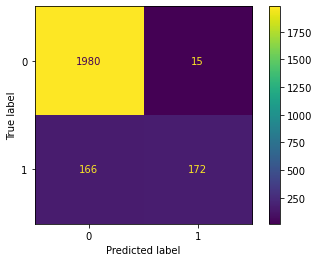

In [31]:
# print training metrics
print_metrics(knn, X_train, y_train)

In [32]:
cross_val_score(knn,
               X=X_train,
               y=y_train).mean()

0.8855575263530341

Accuracy score: 0.898
Precision score: 0.841
Recall score: 0.366
ROC AUC score: 0.823


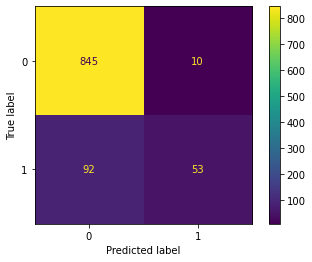

In [33]:
# print test metrics
print_metrics(knn, X_test, y_test)

## Random Forest Pipeline

In [34]:
# Random Forest Pipeline
rcf_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('rcf', RandomForestClassifier(max_depth=6))
])

Accuracy score: 0.957
Precision score: 1.0
Recall score: 0.704
ROC AUC score: 0.956


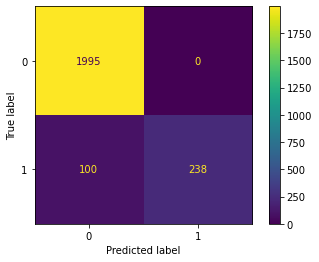

In [35]:
# fit model to training data
rcf_pipe.fit(X_train, y_train)

# print training metrics
print_metrics(rcf_pipe, X_train, y_train)

In [36]:
# cross validation
cross_val_score(rcf_pipe,
               X=X_train,
               y=y_train).mean()

0.9249892014594113

Accuracy score: 0.926
Precision score: 0.938
Recall score: 0.524
ROC AUC score: 0.904


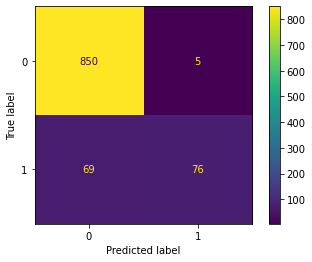

In [37]:
print_metrics(rcf_pipe, X_test, y_test)

## Gradient Boost Pipeline

In [38]:
# Gradient Boost Pipeline
gdb_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('gdb', GradientBoostingClassifier(n_estimators=100))
])

In [39]:
# fit Gradient Boost
gdb_pipe.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('gdb', GradientBoostingClassifier())])

Accuracy score: 0.974
Precision score: 0.983
Recall score: 0.837
ROC AUC score: 0.971


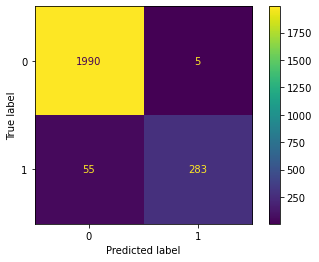

In [40]:
# print training metrics
print_metrics(gdb_pipe, X_train, y_train)

In [208]:
# cross validation
cross_val_score(gdb_pipe,
               X=X_train,
               y=y_train,
               scoring='recall').mean()

0.727875329236172

Accuracy score: 0.948
Precision score: 0.904
Recall score: 0.717
ROC AUC score: 0.901


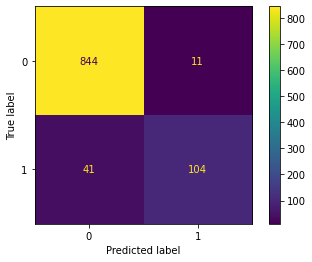

In [209]:
# print test metrics
print_metrics(gdb_pipe, X_test, y_test)

## AdaBoost Classifier

In [43]:
# AdaBoost Classifier Pipeline
adb_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('adb', AdaBoostClassifier())
])

In [44]:
# fit model to training data
adb_pipe.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('adb', AdaBoostClassifier())])

Accuracy score: 0.9
Precision score: 0.742
Recall score: 0.476
ROC AUC score: 0.92


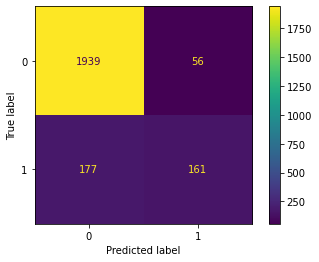

In [45]:
# print training metrics
print_metrics(adb_pipe, X_train, y_train)

Accuracy score: 0.881
Precision score: 0.641
Recall score: 0.407
ROC AUC score: 0.839


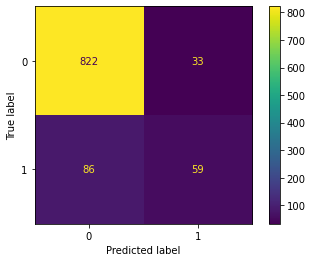

In [46]:
# print training metrics
print_metrics(adb_pipe, X_test, y_test)

## XGBoost

In [47]:
# instanstiate XGBoost
xgb = Pipeline([
    ('ss', StandardScaler()),
    ('xgb', xgboost.XGBClassifier())
])
# fit to training data
xgb.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0
ROC AUC score: 1.0


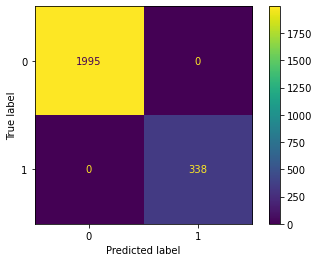

In [48]:
# print training metrics
print_metrics(xgb, X_train, y_train)

In [49]:
# cross validation
cross_val_score(xgb,
               X=X_train,
               y=y_train).mean()

0.9558491329001664

Accuracy score: 0.948
Precision score: 0.891
Recall score: 0.731
ROC AUC score: 0.897


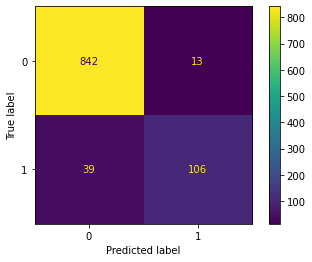

In [50]:
# print test metrics
print_metrics(xgb, X_test, y_test)

## Grid Searching on Gradient Boost

In [51]:
# setting up gradient boost for grid search
# no need to standardize data
gdb_gs = GradientBoostingClassifier()

In [52]:
# set paramaters for grid search
parameters = {}
parameters = {
    "max_depth":[3,5,7,9,11],
    'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    'max_features':['log2','sqrt'],
    'criterion': ['friedman_mse', 'mae', 'mse'],
    'n_estimators':[10,25,50,75]
}

In [53]:
# scoring
scoring = {'accuracy': make_scorer(accuracy_score),
            'recall':make_scorer(recall_score)}

In [54]:
# grid search
gs = GridSearchCV(gdb_gs, parameters, scoring=scoring,cv=5, refit='recall', verbose=1, n_jobs=-1)

In [55]:
# run grid search
gs.fit(X_train, y_train)

Fitting 5 folds for each of 840 candidates, totalling 4200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 4200 out of 4200 | elapsed: 11.1min finished


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'criterion': ['friedman_mse', 'mae', 'mse'],
                         'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15,
                                           0.2],
                         'max_depth': [3, 5, 7, 9, 11],
                         'max_features': ['log2', 'sqrt'],
                         'n_estimators': [10, 25, 50, 75]},
             refit='recall',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'recall': make_scorer(recall_score)},
             verbose=1)

In [56]:
gs.best_estimator_

GradientBoostingClassifier(learning_rate=0.2, max_depth=5, max_features='sqrt',
                           n_estimators=50)

In [57]:
gs.best_score_

0.7279192273924495

In [58]:
gs.cv_results_['mean_test_recall'].max()

0.7279192273924495

In [59]:
pd.set_option('display.max_columns', None)
pd.DataFrame.from_dict(gs.cv_results_).sort_values('mean_test_recall', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_learning_rate,param_max_depth,param_max_features,param_n_estimators,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall
254,0.199666,0.004862,0.005784,3.990414e-04,friedman_mse,0.2,5,sqrt,50,"{'criterion': 'friedman_mse', 'learning_rate':...",0.942184,0.937901,0.963597,0.952790,0.952790,0.949852,0.009031,9,0.691176,0.676471,0.779412,0.761194,0.731343,0.727919,0.039414,1
775,0.312166,0.006675,0.006184,3.990412e-04,mse,0.15,5,sqrt,75,"{'criterion': 'mse', 'learning_rate': 0.15, 'm...",0.952891,0.940043,0.963597,0.948498,0.946352,0.950276,0.007843,8,0.720588,0.691176,0.794118,0.716418,0.716418,0.727744,0.034786,2
770,0.210038,0.003816,0.005984,6.308264e-04,mse,0.15,5,log2,50,"{'criterion': 'mse', 'learning_rate': 0.15, 'm...",0.946467,0.940043,0.959315,0.946352,0.942060,0.946847,0.006709,50,0.705882,0.647059,0.823529,0.746269,0.686567,0.721861,0.060048,3
263,0.553121,0.008166,0.006383,4.884220e-04,friedman_mse,0.2,7,sqrt,75,"{'criterion': 'friedman_mse', 'learning_rate':...",0.950749,0.931478,0.961456,0.952790,0.954936,0.950282,0.010066,5,0.691176,0.588235,0.779412,0.776119,0.761194,0.719227,0.072891,4
218,0.374798,0.017047,0.005984,1.507891e-07,friedman_mse,0.15,7,log2,50,"{'criterion': 'friedman_mse', 'learning_rate':...",0.942184,0.944325,0.963597,0.952790,0.946352,0.949850,0.007735,12,0.676471,0.647059,0.779412,0.761194,0.731343,0.719096,0.050133,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,0.894808,0.049745,0.005784,1.163350e-03,mae,0.025,5,log2,10,"{'criterion': 'mae', 'learning_rate': 0.025, '...",0.854390,0.854390,0.854390,0.856223,0.856223,0.855123,0.000898,697,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,697
325,1.538089,0.033593,0.005186,3.989458e-04,mae,0.025,3,sqrt,25,"{'criterion': 'mae', 'learning_rate': 0.025, '...",0.854390,0.854390,0.854390,0.856223,0.856223,0.855123,0.000898,697,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,697
324,0.560901,0.025479,0.005186,3.989220e-04,mae,0.025,3,sqrt,10,"{'criterion': 'mae', 'learning_rate': 0.025, '...",0.854390,0.854390,0.854390,0.856223,0.856223,0.855123,0.000898,697,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,697
597,0.651858,0.031142,0.006183,3.988743e-04,mse,0.01,11,sqrt,25,"{'criterion': 'mse', 'learning_rate': 0.01, 'm...",0.854390,0.854390,0.854390,0.856223,0.856223,0.855123,0.000898,697,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,697


In [60]:
pd.DataFrame.from_dict(gs.cv_results_).sort_values('mean_test_recall', ascending=False).params.iloc[0]

{'criterion': 'friedman_mse',
 'learning_rate': 0.2,
 'max_depth': 5,
 'max_features': 'sqrt',
 'n_estimators': 50}

Accuracy score: 0.992
Precision score: 0.997
Recall score: 0.95
ROC AUC score: 0.997


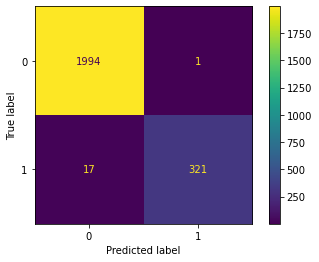

In [61]:
print_metrics(gs.best_estimator_.fit(X_train, y_train), X_train, y_train)

Accuracy score: 0.942
Precision score: 0.866
Recall score: 0.71
ROC AUC score: 0.905


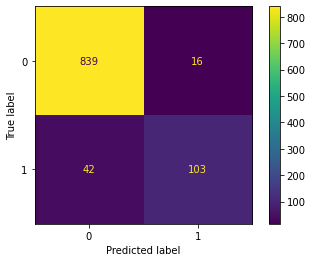

In [62]:
print_metrics(gs.best_estimator_.fit(X_train, y_train), X_test, y_test)

In [204]:
gdb = GradientBoostingClassifier(loss = 'exponential', learning_rate=0.2, max_depth=5, max_features='sqrt',
                           n_estimators=50, subsample=1)

gdb.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=5,
                           max_features='sqrt', n_estimators=50, subsample=1)

In [205]:
gdb.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.2,
 'loss': 'exponential',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Accuracy score: 0.98
Precision score: 1.0
Recall score: 0.864
ROC AUC score: 0.999


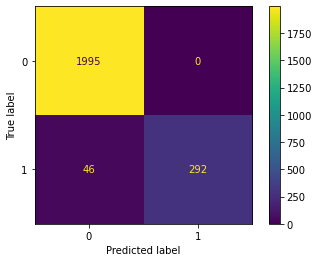

In [206]:
print_metrics(gdb, X_train, y_train)

Accuracy score: 0.945
Precision score: 0.902
Recall score: 0.697
ROC AUC score: 0.912


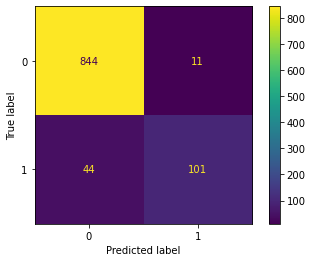

In [207]:
print_metrics(gdb, X_test, y_test)

In [191]:
gdb.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.2,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}